# Exercise 3
Due:  Tue November 12, 8:00am

In [1]:
!pip install torch_geometric ogb torch-scatter networkx tabulate -f https://data.pyg.org/whl/torch-2.4.1+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.4.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 94.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.2 MB/s eta 0:00:00


Names of all participants working on this exercise: Muneeb, Bashar, Shameer





In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch_geometric as pyg
import ogb.graphproppred
import ogb.graphproppred.mol_encoder
from tqdm import tqdm
import torch_scatter
import sklearn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os

In [4]:
# find device
if torch.cuda.is_available():  # NVIDIA
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # apple M1/M2
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='cuda')

ppa = ogb.graphproppred.PygGraphPropPredDataset(name="ogbg-ppa")

In [5]:
dataset = pyg.datasets.LRGBDataset(root="dataset/peptides-func", name="Peptides-func")
peptides_train = pyg.datasets.LRGBDataset(
    root="dataset/peptides-func", name="Peptides-func", split="train"
)
peptides_val = pyg.datasets.LRGBDataset(
    root="dataset/peptides-func", name="Peptides-func", split="val"
)
peptides_test = pyg.datasets.LRGBDataset(
    root="dataset/peptides-func", name="Peptides-func", split="test"
)

batch_size = 32
train_loader = pyg.loader.DataLoader(
    peptides_train, batch_size=batch_size, shuffle=True
)
val_loader = pyg.loader.DataLoader(peptides_val, batch_size=batch_size, shuffle=True)
test_loader = pyg.loader.DataLoader(peptides_test, batch_size=batch_size, shuffle=True)

Extracting dataset/peptides-func/peptidesfunc.zip
Processing...
Processing test dataset: 100%|██████████| 2331/2331 [00:00<00:00, 33786.46it/s]
Done!


In [6]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


set_seed()

Random seed set as 42


In this exercise, we will expand our sparse GNNs. For reference, I attached my version of the GCNLayer module (for those who did have problems with exercise 2).

For next week please:
1. Implement virtual nodes
2. Implement GINE (GIN+Edge features) based on the sparse implementation from Exercise 2
3. Test everything (especially the effects of virtual nodes and edge features) on peptides-func.
4. Draw the molecule peptides_train[0]

Expected performance of the GNNs would be to reach more than 0.6 AP. (0.68 is within reach using simple and small networks).

In [7]:
class GCNLayer(torch.nn.Module):
    def __init__(
        self, in_features: int, out_features: int, activation=torch.nn.functional.relu
    ):
        super(GCNLayer, self).__init__()
        self.activation = activation
        self.W: torch.Tensor = torch.nn.Parameter(
            torch.zeros(in_features, out_features)
        )
        torch.nn.init.kaiming_normal_(self.W)

    def forward(self, H: torch.Tensor, edge_index: torch.Tensor):
        out = H.clone()
        new_H = torch_scatter.scatter_add(
            H[edge_index[0]], edge_index[1], dim=0, dim_size=out.shape[0]
        )
        out = out + new_H
        out = out.matmul(self.W)
        if self.activation:
            out = self.activation(out)
        return out

In [8]:
# def evaluate(loader, model):

#     y_pred = []
#     y_true = []
#     model.eval()
#     with torch.no_grad():
#         for batch in loader:
#             batch = batch.to(next(model.parameters()).device)
#             outputs = model(batch.x, batch.edge_index, batch.batch)
#             y_pred.extend(outputs.cpu().numpy())
#             y_true.extend(batch.y.cpu().numpy())

#     ap_score = sklearn.metrics.average_precision_score(y_true, y_pred)
#     # print(f"Average Precision Score: {ap_score:.4f}")
#     return ap_score


def evaluate(loader, model, num_classes=10):
    """
    Evaluates the model on the given data loader and computes mean Average Precision (mAP)
    as well as per-class Average Precision (AP).

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        loader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): Device to perform computations on.
        num_classes (int): Number of classes in the dataset.
        average (str): Averaging method for mAP. Options: 'macro', 'weighted', 'micro', 'samples'.

    Returns:
        float: Mean Average Precision (mAP) across all classes.
        list: List of Average Precision scores for each class.
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)

            # if batch.x.dtype != torch.float:
            #     batch.x = batch.x.float()
            # if batch.edge_attr is not None and batch.edge_attr.dtype != torch.float:
            #     batch.edge_attr = batch.edge_attr.float()

            logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            probabilities = torch.sigmoid(logits)

            y_pred.append(probabilities.cpu())
            y_true.append(batch.y.cpu())

    # Concatenate all batches
    y_pred = torch.cat(y_pred, dim=0).numpy()  # Shape: (total_samples, num_classes)
    y_true = torch.cat(y_true, dim=0).numpy()  # Shape: (total_samples, num_classes)

    # Initialize list to hold per-class AP
    ap_per_class = []
    for i in range(num_classes):
        # Check if there are positive samples for the class
        if np.sum(y_true[:, i]) == 0:
            ap = np.nan  # Use NaN to indicate no positive samples
        else:
            ap = sklearn.metrics.average_precision_score(y_true[:, i], y_pred[:, i])
        ap_per_class.append(ap)

    # Compute mean AP, ignoring classes with no positive samples
    ap_per_class_clean = [ap for ap in ap_per_class if not np.isnan(ap)]
    mean_ap = np.mean(ap_per_class_clean)

    # Optional: Print per-class AP for detailed insights
    # for idx, ap in enumerate(ap_per_class):
    #     if not np.isnan(ap):
    #         print(f"Class {idx}: AP = {ap:.4f}")
    #     else:
    #         print(f"Class {idx}: AP = NaN (No positive samples)")

    # print(f"Mean Average Precision (mAP): {mean_ap:.4f}")

    return mean_ap, ap_per_class

# Data Exploration

In [9]:
dataset.print_summary()

100%|██████████| 10873/10873 [00:01<00:00, 7643.83it/s]

LRGBDataset (#graphs=10873):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    151.5 |    308.5 |
| std        |     84.1 |    172   |
| min        |      8   |     10   |
| quantile25 |     91   |    186   |
| median     |    137   |    278   |
| quantile75 |    205   |    416   |
| max        |    444   |    928   |
+------------+----------+----------+


In [10]:
sample_data = peptides_train[0]
sample_data

Data(x=[338, 9], edge_index=[2, 682], edge_attr=[682, 3], y=[1, 10])

# Modeling

In [29]:
class GIN_ELayer(torch.nn.Module):

    def __init__(
        self,
        in_features: int,
        out_features: int,
        activation=torch.nn.functional.relu,
        reduction="mean",
        use_edge_features: bool = False,
        edge_dim: int = 0,
        mlp_n_layers: int = 3,
        dropout: float = 0.1,
    ):
        super(GIN_ELayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation
        self.reduction = reduction
        self.use_edge_features = use_edge_features
        self.edge_dim = edge_dim
        self.eps = torch.nn.Parameter(torch.randn(1) * 0.01)
        self.mlp_n_layers = mlp_n_layers
        self.dropout = dropout
        self.edge_embedding = None
        if self.use_edge_features:
            self.edge_embedding = torch.nn.Linear(edge_dim, in_features)

        self.mlp = torch.nn.ModuleList(
            [
                torch.nn.Sequential(
                    torch.nn.Linear(
                        in_features if i == 0 else out_features,
                        out_features,
                        bias=False,
                    ),
                    torch.nn.BatchNorm1d(out_features),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(self.dropout),
                )
                for i in range(self.mlp_n_layers)
            ]
        )
        # initialize weights
        for mlp_layer in self.mlp:
            torch.nn.init.kaiming_normal_(mlp_layer[0].weight)

    def forward(
        self, H: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor = None
    ):
        src, dst = edge_index
        H_j = H[dst]
        message = H_j
        if self.use_edge_features:
            assert (
                edge_attr is not None
            ), "Edge features active, Edge attributes are required for GIN_ELayer"
            message = message + self.edge_embedding(edge_attr.float())
        # non-linearity on the message
        message = self.activation(message)
        # sum the messages ai
        a_i = torch_scatter.scatter_add(message, src, dim=0, dim_size=H.shape[0])
        # MLP input
        H = (1 + self.eps) * H + a_i
        # MLP forward pass
        for mlp_layer in self.mlp:
            H = mlp_layer(H)
        return H

In [12]:
class VirtualNode(torch.nn.Module):

    def __init__(self, in_features: int, activation=torch.nn.functional.relu):
        super(VirtualNode, self).__init__()
        self.in_features = in_features
        self.activation = activation
        self.eps = torch.nn.Parameter(torch.randn(1) * 0.01)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(in_features, in_features),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features, in_features),
        )

    def forward(
        self, H: torch.Tensor, batch_idx: torch.Tensor, current_vn_state: torch.Tensor
    ):
        num_graph = batch_idx.max().item() + 1
        # global node feature aggregation through sum of node features per graph (via batch_idx)
        sum_H = torch_scatter.scatter_add(H, batch_idx, dim=0, dim_size=num_graph)
        mlp_input = (1 + self.eps) * current_vn_state + sum_H
        new_vn_state = self.mlp(mlp_input)
        # broadcast new virtual node state to all nodes in the graph
        new_H = H + new_vn_state[batch_idx]
        return new_H, new_vn_state

In [57]:
class GIN_E_Network(torch.nn.Module):

    def __init__(
        self,
        in_features: int,
        hidden_features: int,
        num_layers: int,
        num_classes: int,
        activation=torch.nn.functional.relu,
        dropout: float = 0.1,
        mlp_n_layers: int = 3,
        use_edge_features: bool = False,
        edge_dim: int = 0,
        use_virtual_nodes: bool = False,
        global_pooling_reduction: str = "mean",
    ):
        super(GIN_E_Network, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.activation = activation
        self.dropout = dropout
        self.mlp_n_layers = mlp_n_layers
        self.use_edge_features = use_edge_features
        self.edge_dim = edge_dim
        self.use_virtual_nodes = use_virtual_nodes
        self.global_pooling_reduction = global_pooling_reduction
        self._vn_block = lambda: torch.nn.Sequential(
            VirtualNode(hidden_features, activation), torch.nn.Dropout(dropout)
        )
        self._conv_block = lambda i: torch.nn.Sequential(
            GIN_ELayer(
                in_features if i == 0 else hidden_features,
                hidden_features,
                activation,
                dropout,
                use_edge_features,
                edge_dim,
                mlp_n_layers,
            ),
            torch.nn.BatchNorm1d(hidden_features),
            torch.nn.ReLU() if i < num_layers - 1 else torch.nn.Identity(),
            torch.nn.Dropout(dropout),
        )

        self.layers = []
        self._layer_identifier = []
        for i in range(num_layers):
            self.layers.append(self._conv_block(i))
            self._layer_identifier.append("conv")
            if use_virtual_nodes:
                self.layers.append(self._vn_block())
                self._layer_identifier.append("vn")
        self.layers = torch.nn.ModuleList(self.layers)
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, hidden_features),
            torch.nn.BatchNorm1d(hidden_features),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_features, num_classes),
        )

    def forward(
        self,
        H: torch.Tensor,
        edge_index: torch.Tensor,
        edge_attr: torch.Tensor = None,
        batch_idx: torch.Tensor = None,
    ):
        vn_state = None
        num_graphs = batch_idx.max().item() + 1
        if self.use_virtual_nodes:
            vn_state = torch.zeros(num_graphs, self.hidden_features).to(H.device)

        for i in range(len(self.layers)):
            # if convolutional layer, pass in edge_attr
            if self._layer_identifier[i] == "conv":
                H = self.layers[i][0](H, edge_index, edge_attr)
                H = self.layers[i][1](H)
                H = self.layers[i][2](H)
                H = self.layers[i][3](H)
            else:
                # if virtual node layer, pass in batch_idx and vn_state
                H, vn_state = self.layers[i][0](H, batch_idx, vn_state)
                H = self.layers[i][1](H)
        # Global pooling
        H = pyg.utils.scatter(
            H,
            batch_idx,
            dim=0,
            dim_size=num_graphs,
            reduce=self.global_pooling_reduction,
        )
        return self.output_layer(H)

In [39]:
def train_and_evaluate(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_classes=10,
    epochs=100,
    lr=1e-3,
    weight_decay=1e-4,
    patience=20,
    device="cuda",
):
    print(f"Training model with configuration:")
    print(f"- Virtual Nodes: {model.use_virtual_nodes}")
    print(f"- Edge Features: {model.use_edge_features}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr/100)
    criterion = torch.nn.CrossEntropyLoss()

    model = model.to(device)

    best_val_ap = 0.0
    best_test_ap = 0.0
    best_epoch = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            loss = criterion(outputs, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()

        # validation on test and validation set
        val_ap, val_aps = evaluate(val_loader, model, num_classes)
        test_ap, test_aps = evaluate(test_loader, model, num_classes)

        if val_ap > best_val_ap:
            best_val_ap = val_ap
            best_test_ap = test_ap
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            current_lr = optimizer.param_groups[0]["lr"]
            print(
                f"Epoch {epoch}: Loss = {total_loss/len(train_loader):.4f}, "
                f"Val AP = {val_ap:.4f}, Test AP = {test_ap:.4f}, "
                f"LR = {current_lr:.2e}"
            )
    print("Training complete...Final Results:")
    print(f"Best validation AP: {best_val_ap:.4f} at epoch {best_epoch}")
    print(f"Best test AP: {best_test_ap:.4f} at epoch {best_epoch}")

    return best_val_ap, best_test_ap

In [54]:
# Base parameters
base_params = {
    "in_features": dataset[0].x.size(1),
    "hidden_features": 128,
    "edge_dim": dataset[0].edge_attr.size(1),
    "num_layers": 3,
    "dropout": 0.0,
    "num_classes": 10
}

# Training parameters
train_params = {
    "epochs": 200,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "device": device,
}

In [55]:
# Training the Updated Model
print("\n=== Training Full Model (Virtual Nodes + Edge Features) ===")
model_full = GIN_E_Network(**base_params, use_virtual_nodes=True, use_edge_features=True)
results_full = train_and_evaluate(
    model_full, train_loader, val_loader, test_loader, base_params["num_classes"],**train_params
)


=== Training Full Model (Virtual Nodes + Edge Features) ===
Training model with configuration:
- Virtual Nodes: True
- Edge Features: True
Epoch 0: Loss = 2.7435, Val AP = 0.3856, Test AP = 0.3741, LR = 1.00e-03
Epoch 10: Loss = 2.3974, Val AP = 0.4706, Test AP = 0.4517, LR = 9.93e-04
Epoch 20: Loss = 2.2997, Val AP = 0.5169, Test AP = 0.4860, LR = 9.73e-04
Epoch 30: Loss = 2.2062, Val AP = 0.5368, Test AP = 0.5281, LR = 9.42e-04
Epoch 40: Loss = 2.1180, Val AP = 0.5668, Test AP = 0.5350, LR = 9.01e-04
Epoch 50: Loss = 2.0426, Val AP = 0.5604, Test AP = 0.5471, LR = 8.49e-04
Epoch 60: Loss = 1.9528, Val AP = 0.5812, Test AP = 0.5749, LR = 7.90e-04
Epoch 70: Loss = 1.8908, Val AP = 0.5779, Test AP = 0.5751, LR = 7.23e-04
Epoch 80: Loss = 1.8164, Val AP = 0.5856, Test AP = 0.5859, LR = 6.51e-04
Epoch 90: Loss = 1.7520, Val AP = 0.5964, Test AP = 0.5924, LR = 5.75e-04
Epoch 100: Loss = 1.6874, Val AP = 0.5985, Test AP = 0.5964, LR = 4.97e-04
Epoch 110: Loss = 1.6384, Val AP = 0.5996, Tes

In [58]:
print("\n=== Training Without Virtual Nodes (Include Edge Features) ===")
model_no_virtual_nodes = GIN_E_Network(
    **base_params, use_virtual_nodes=False, use_edge_features=True
)
results_no_virtual_nodes = train_and_evaluate(
    model_no_virtual_nodes, train_loader, val_loader, test_loader, base_params["num_classes"],**train_params
)


=== Training Without Virtual Nodes (Include Edge Features) ===
Training model with configuration:
- Virtual Nodes: False
- Edge Features: True
Epoch 0: Loss = 2.8297, Val AP = 0.3896, Test AP = 0.3736, LR = 1.00e-03
Epoch 10: Loss = 2.3341, Val AP = 0.5027, Test AP = 0.4824, LR = 9.93e-04
Epoch 20: Loss = 2.2221, Val AP = 0.5389, Test AP = 0.5005, LR = 9.73e-04
Epoch 30: Loss = 2.1476, Val AP = 0.5491, Test AP = 0.5144, LR = 9.42e-04
Epoch 40: Loss = 2.0929, Val AP = 0.5665, Test AP = 0.5382, LR = 9.01e-04
Epoch 50: Loss = 2.0492, Val AP = 0.5483, Test AP = 0.5307, LR = 8.49e-04
Early stopping at epoch 60
Training complete...Final Results:
Best validation AP: 0.5665 at epoch 40
Best test AP: 0.5382 at epoch 40


In [59]:
print("\n=== Training Without Virtual Nodes and Edge Features ===")
model_base = GIN_E_Network(
    **base_params, use_virtual_nodes=False, use_edge_features=False
)
results_base = train_and_evaluate(
    model_base, train_loader, val_loader, test_loader, base_params["num_classes"],**train_params
)


=== Training Without Virtual Nodes and Edge Features ===
Training model with configuration:
- Virtual Nodes: False
- Edge Features: False
Epoch 0: Loss = 2.8244, Val AP = 0.3923, Test AP = 0.3802, LR = 1.00e-03
Epoch 10: Loss = 2.3241, Val AP = 0.5033, Test AP = 0.4795, LR = 9.93e-04
Epoch 20: Loss = 2.2261, Val AP = 0.5312, Test AP = 0.4999, LR = 9.73e-04
Epoch 30: Loss = 2.1511, Val AP = 0.5406, Test AP = 0.5121, LR = 9.42e-04
Epoch 40: Loss = 2.0897, Val AP = 0.5342, Test AP = 0.5123, LR = 9.01e-04
Epoch 50: Loss = 2.0435, Val AP = 0.5452, Test AP = 0.5216, LR = 8.49e-04
Epoch 60: Loss = 1.9996, Val AP = 0.5472, Test AP = 0.5217, LR = 7.90e-04
Epoch 70: Loss = 1.9610, Val AP = 0.5539, Test AP = 0.5266, LR = 7.23e-04
Epoch 80: Loss = 1.9356, Val AP = 0.5578, Test AP = 0.5358, LR = 6.51e-04
Epoch 90: Loss = 1.9049, Val AP = 0.5509, Test AP = 0.5414, LR = 5.75e-04
Epoch 100: Loss = 1.8822, Val AP = 0.5573, Test AP = 0.5370, LR = 4.97e-04
Early stopping at epoch 103
Training complete..

In [60]:
print("\n=== Training With Virtual Nodes and without Edge Features ===")
model_no_edge = GIN_E_Network(
    **base_params, use_virtual_nodes=True, use_edge_features=False
)
results_base = train_and_evaluate(
    model_no_edge, train_loader, val_loader, test_loader, base_params["num_classes"],**train_params
)


=== Training With Virtual Nodes and without Edge Features ===
Training model with configuration:
- Virtual Nodes: True
- Edge Features: False
Epoch 0: Loss = 2.7461, Val AP = 0.3860, Test AP = 0.3672, LR = 1.00e-03
Epoch 10: Loss = 2.4141, Val AP = 0.4748, Test AP = 0.4468, LR = 9.93e-04
Epoch 20: Loss = 2.3008, Val AP = 0.5330, Test AP = 0.4947, LR = 9.73e-04
Epoch 30: Loss = 2.1928, Val AP = 0.5584, Test AP = 0.5232, LR = 9.42e-04
Epoch 40: Loss = 2.1153, Val AP = 0.5707, Test AP = 0.5415, LR = 9.01e-04
Epoch 50: Loss = 2.0184, Val AP = 0.5733, Test AP = 0.5541, LR = 8.49e-04
Epoch 60: Loss = 1.9544, Val AP = 0.5872, Test AP = 0.5689, LR = 7.90e-04
Epoch 70: Loss = 1.8813, Val AP = 0.5934, Test AP = 0.5741, LR = 7.23e-04
Epoch 80: Loss = 1.8102, Val AP = 0.5953, Test AP = 0.5816, LR = 6.51e-04
Epoch 90: Loss = 1.7261, Val AP = 0.5921, Test AP = 0.5892, LR = 5.75e-04
Early stopping at epoch 98
Training complete...Final Results:
Best validation AP: 0.6067 at epoch 78
Best test AP: 0.5

# Data Visualization

In [63]:
def draw_molecule(data, def_col=0):
    G = pyg.utils.to_networkx(data, to_undirected=True)
    node_features = data.x.numpy()
    edge_index = data.edge_index.numpy()
    edge_attr = data.edge_attr.numpy()
    bond_types = edge_attr[:, 0].astype(int)
    atom_types = None
    atom_type_indices = None
    for i, (u, v) in enumerate(zip(edge_index[0], edge_index[1])):
        G.edges[u, v]["bond_type"] = bond_types[i]
    if def_col == 0:
        atom_types = {
            5: "C",
            6: "N",
            7: "O",
        }
        atom_type_indices = node_features[:, def_col].astype(int)
    elif def_col == 2:
        atom_types = {4: "C", 3: "O", 1: "N"}
        atom_type_indices = node_features[:, def_col].astype(int)
    elif def_col == 4:
        atom_types = {1: "C", 0: "O", 2: "N"}
        atom_type_indices = node_features[:, def_col].astype(int)
    bond_color_mapping = {
        0: "black",
        1: "blue",
        3: "red",
    }
    edges = list(G.edges())
    edge_colors = []
    for u, v in edges:
        bond_type = G.edges[u, v]["bond_type"]
        color = bond_color_mapping.get(bond_type, "green")
        edge_colors.append(color)
    labels = {
        i: atom_types.get(atom_type_indices[i], "X")
        for i in range(atom_type_indices.shape[0])
    }
    size = 12
    plt.figure(figsize=(size, size))
    pos = nx.kamada_kawai_layout(G, scale=5)
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=50,
        node_color="lightblue",
        edgelist=edges,
        edge_color=edge_colors,
        width=1.5,
    )
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_weight="bold")
    plt.title("Molecule Visualization of peptides_train[0]")
    plt.axis("off")
    plt.show()

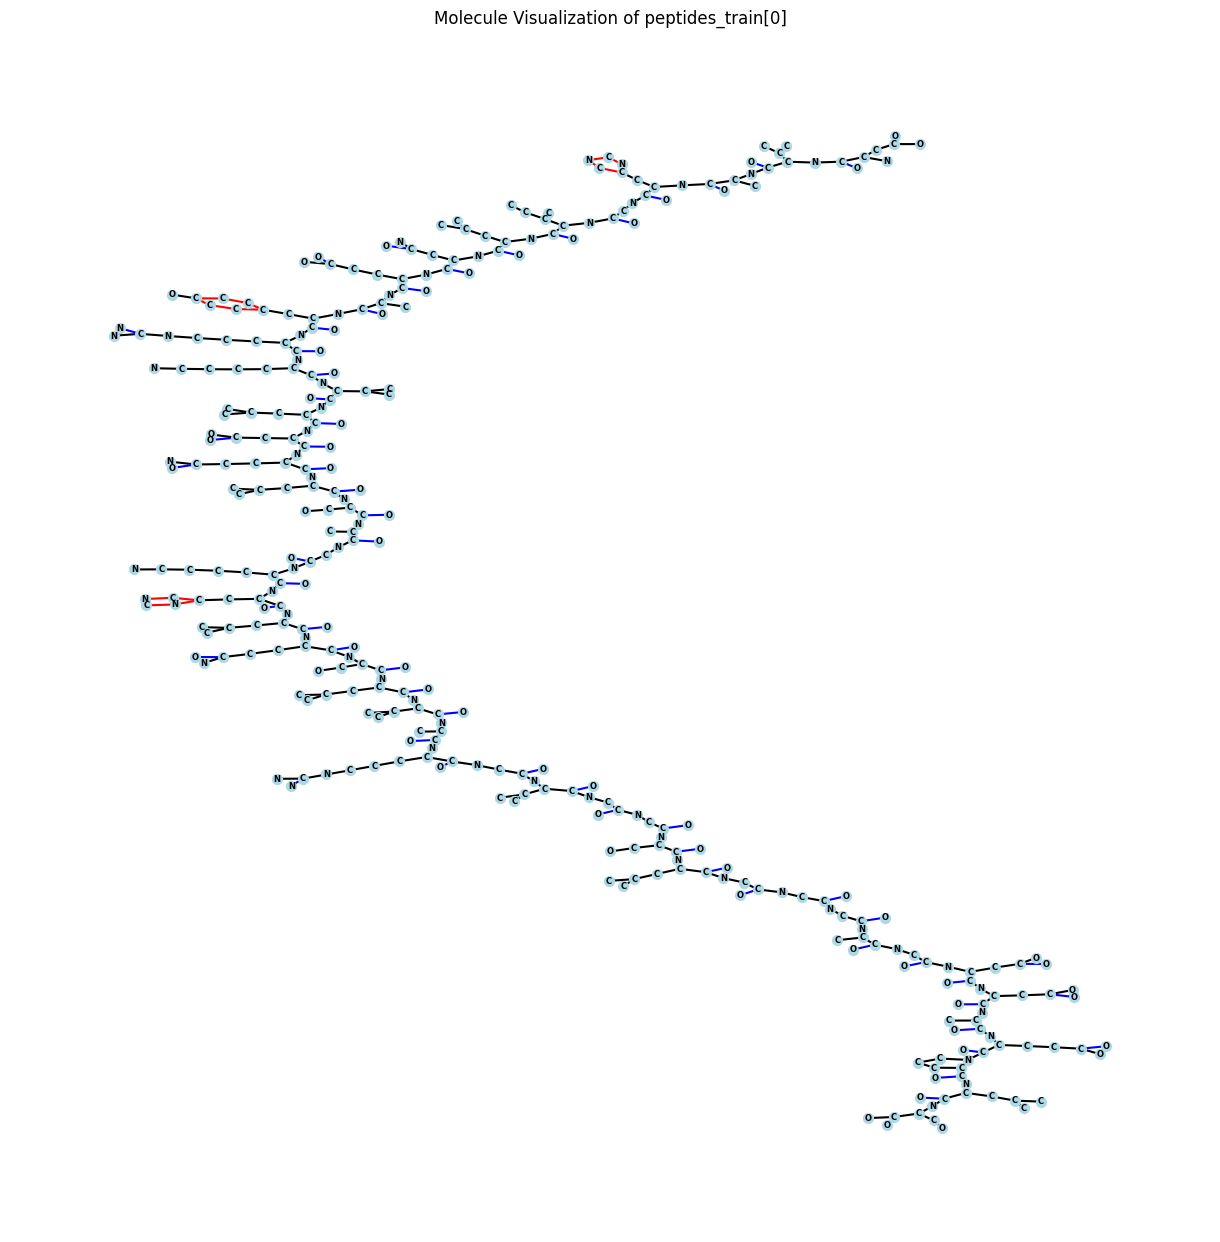

In [64]:
draw_molecule(peptides_train[0], def_col=0)